In [1]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
  
from xroms import (roms_dataset,
                   open_roms_netcdf_dataset,
                   to_rho, 
                   hgrad)
from scipy import signal

import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

Calculate TEF for a 3D control volume, neglecting vertical fluxes because they are orders of magnitude smaller than the horizontal fluxes in the TX-LA model. This notebook is intended for smaller timesteps (e.g. <100 hours), otherwise a script will have to be run in the background. Therefore, the data is not filtered in time (e.g. convolved). In practice, the histograms of the individual control surfaces, or net histogram, may be saved as a netcdf. Then, load the data in and apply a custom convolution filter using Xarray's ufunc. This is shown in another notebook. Note the sign method is applied here.

We need to calculate the salt, volume transport, salinity transport, salinity squared transport, and salinity variance transport at each face. 

In [2]:
def salt_faces(ds, grid, xislice, etaslice):
    '''
Computes the salinity at each corner of a slice of ROMS model output.
Currently designed for boxes.
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
-----
Output:
s'variable': salinity at the west, east, north, and south box faces
    '''
    su = grid.interp(ds.salt, 'X')
    sv = grid.interp(ds.salt, 'Y')


    su = su.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    sv = sv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)
    
    sW = su.isel(xi_u = 0) 
    sE = su.isel(xi_u = -1) 
    sN = sv.isel(eta_v = -1) 
    sS = sv.isel(eta_v = 0) 
   
    sW.name = 'sW'
    sE.name = 'sE'
    sN.name = 'sN'
    sS.name = 'sS'
    
    return sW, sE, sN, sS

In [3]:
def Qc_faces(ds, grid, xislice, etaslice, tracer):
    '''
Computes the boundary transport of a tracer along a specified slice of ROMS output. 
Options are currently limited to salt, salt squared. Currently
functionalized for a box. 
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
tracer - str Current options are 'salt', 's2', or 
-----
Output:
Qc'variable': Tracer flux at the west, east, north, and south box faces
    '''
    su = grid.interp(ds.salt, 'X')
    sv = grid.interp(ds.salt, 'Y')

    if tracer=='salt':
        Qcu = ds.dz_u*ds.dy_u*ds.u*su
        Qcv = ds.dz_v*ds.dx_v*ds.v*sv
        
    if tracer=='s2':
        Qcu = ds.dz_u*ds.dy_u*ds.u*(su**2)
        Qcv = ds.dz_v*ds.dx_v*ds.v*(sv**2)
        
    Qcu = Qcu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    Qcv = Qcv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QcW = Qcu.isel(xi_u = 0) 
    QcE = Qcu.isel(xi_u = -1) 
    QcN = Qcv.isel(eta_v = -1) 
    QcS = Qcv.isel(eta_v = 0) 
    
    QcW.name = 'QcW'
    QcE.name = 'QcE'
    QcN.name = 'QcN'
    QcS.name = 'QcS'
    
    return QcW, QcE, QcN, QcS

In [4]:
def Q_faces(ds, xislice, etaslice):
    '''
Computes the volume transport of a tracer along a specified slice of ROMS output. 
Options are currently limited to salt, salt squared. Currently
functionalized for a box. 
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
tracer - str Current options are 'salt', 's2', or 
-----
Output:
Qc'variable': Tracer flux at the west, east, north, and south box faces
    '''
    Qu = ds.dz_u*ds.dy_u*ds.u
    Qv = ds.dz_v*ds.dx_v*ds.v

    Qu = Qu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    Qv = Qv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QW = Qu.isel(xi_u = 0) #west
    QE = Qu.isel(xi_u = -1) #east
    QN = Qv.isel(eta_v = -1) #top
    QS = Qv.isel(eta_v = 0) #bottom
    
    QW.name = 'QW'
    QE.name = 'QE'
    QN.name = 'QN'
    QS.name = 'QS'
    
    return QW, QE, QN, QS

In [5]:
def Qcsvar_faces(ds, grid, sW, sE, sN, sS, QW, QE, QN, QS,xislice, etaslice):
    '''
Computes the boundary fluxes of salinity variance along a specified slice of ROMS output. 
Currently functionalized for a box.
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice - slice object of desired eta grid points
s'variable' - salinity at each face of the box
Q'variable' - volume flux at each face of the box
-----
Output:
Qc'variable': svar transport at the west, east, north, and south box faces
svar'variable': svar at the west, east, north, and south box faces
    '''
 
    dVu = ds.dy_u*ds.dz_u
    dVu = dVu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    dVv = ds.dx_v*ds.dz_v
    dVv = dVv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)
    
    dVW = dVu.isel(xi_u = 0) 
    dVE = dVu.isel(xi_u = -1) 
    dVN = dVv.isel(eta_v = -1) 
    dVS = dVv.isel(eta_v = 0) 
    
    VW = dVW.sum(dim = ['eta_rho','s_rho'])
    VE = dVE.sum(dim = ['eta_rho','s_rho'])
    VN = dVN.sum(dim = ['xi_rho','s_rho'])
    VS = dVS.sum(dim = ['xi_rho','s_rho'])

    sbarW = ((sW*dVW).sum(dim = ['eta_rho','s_rho']))/VW
    sbarE = ((sE*dVE).sum(dim = ['eta_rho','s_rho']))/VE
    sbarN = ((sN*dVN).sum(dim = ['xi_rho','s_rho']))/VN
    sbarS = ((sS*dVS).sum(dim = ['xi_rho','s_rho']))/VS
    
    svarW = ((sW-sbarW)**2)
    svarE = ((sE-sbarE)**2)
    svarN = ((sN-sbarN)**2)
    svarS = ((sS-sbarS)**2)
    
    QsvarW = QW*svarW
    QsvarE = QE*svarE
    QsvarN = QN*svarN
    QsvarS = QS*svarS
    
    QsvarW.name = 'QsvarW'
    QsvarE.name = 'QsvarE'
    QsvarN.name = 'QsvarN'
    QsvarS.name = 'QsvarS'

    svarW.name = 'svarW'
    svarE.name = 'svarE'
    svarN.name = 'svarN'
    svarS.name = 'svarS'
    
    return QsvarW, QsvarE, QsvarN, QsvarS, svarW, svarE, svarN, svarS

Load in data using xroms, define box slices

In [6]:
path = '/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_00*.nc'
ds = open_roms_netcdf_dataset(path, chunks = {'ocean_time':1})
ds, grid = roms_dataset(ds, Vtransform = None)

xislice=slice(320,375)
etaslice=slice(60,145)

In [7]:
sW, sE, sN, sS = salt_faces(ds, grid, xislice, etaslice)
sW2 = sW**2
sW2.name = 'sW2'
sE2 = sE**2
sE2.name = 'sE2'
sN2 = sN**2
sN2.name = 'sN2'
sS2 = sS**2
sS2.name = 'sS2'

QW, QE, QN, QS = Q_faces(ds, xislice, etaslice)

QcW, QcE, QcN, QcS = Qc_faces(ds, grid, xislice, etaslice, 'salt')
QsW = QcW
QsE = QcE
QsN = QcN
QsS = QcS

QcW, QcE, QcN, QcS = Qc_faces(ds, grid, xislice, etaslice, 's2')
QssW = QcW
QssE = QcE
QssN = QcN
QssS = QcS

QsvarW, QsvarE, QsvarN, QsvarS, svarW, svarE, svarN, svarS = \
    Qcsvar_faces(ds, grid, sW, sE, sN, sS, QW, QE, QN, QS, xislice, etaslice)

Plot the box location

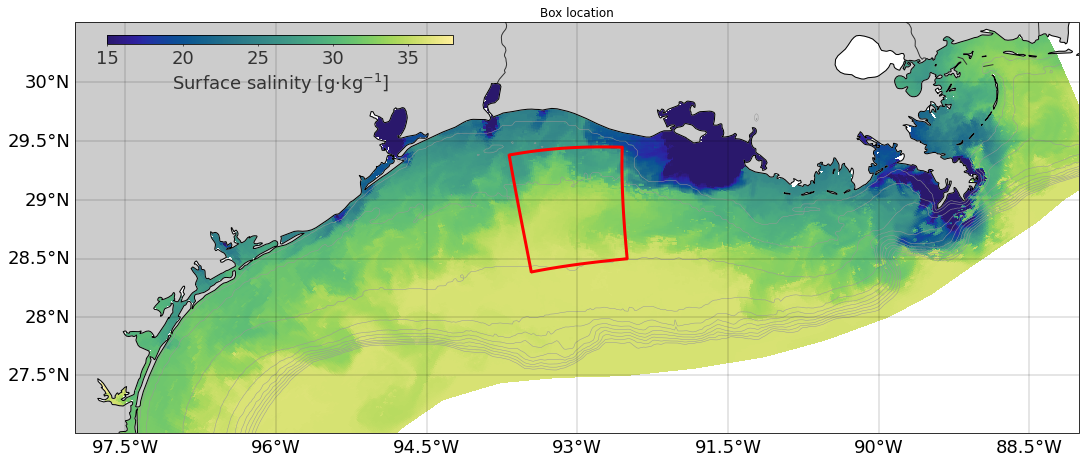

In [8]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))

sal = ds.salt.sel(ocean_time='2010-01-01-01').isel(s_rho=-1).values
lon_rho = ds.salt['lon_rho'][:].data
lat_rho = ds.salt['lat_rho'][:].data
hlevs = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450]  # isobath contour depths

mappable = ax.pcolormesh(lon_rho, lat_rho, sal, cmap = cmo.haline, transform = cartopy.crs.PlateCarree(),
                        vmin = 15, vmax = 38)

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-94, -91.5, 28.3, 29.6], ccrs.PlateCarree())
ax.set_extent([-98, -88, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface salinity [g$\cdot$kg$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

ax.contour(lon_rho, lat_rho, ds.h, hlevs, colors='0.6', transform=ccrs.PlateCarree(), linewidths=0.5)
ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.plot(QcN.lon_v.values, QcN.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QcS.lon_v.values, QcS.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QcE.lon_u.values, QcE.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QcW.lon_u.values, QcW.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.set_title('Box location')

plt.rcParams.update({'font.size': 18})

In [9]:
def svar_hist(tslice, tbins1, svarW, svarE, svarN, svarS, sW, sE, sN, sS, QsvarW, QsvarE, QsvarN, QsvarS):
    qsvarWh = histogram(sW.isel(ocean_time = tslice), svarW.isel(ocean_time = tslice), bins = tbins1, weights = QsvarW.isel(ocean_time = tslice),
                     dim = ['s_rho', 'eta_rho'])
    qsvarEh = histogram(sE.isel(ocean_time = tslice), svarE.isel(ocean_time = tslice), bins = tbins1, weights = QsvarE.isel(ocean_time = tslice),
                      dim = ['s_rho', 'eta_rho'])
    qsvarNh = histogram(sN.isel(ocean_time = tslice), svarN.isel(ocean_time = tslice), bins = tbins1, weights = QsvarN.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    qsvarSh = histogram(sS.isel(ocean_time = tslice), svarS.isel(ocean_time = tslice), bins = tbins1, weights = QsvarS.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    return qsvarWh, qsvarEh, qsvarNh, qsvarSh

def ssquared_hist(tslice, tbins, sW2, sE2, sN2, sS2, sW, sE, sN, sS, QssW, QssE, QssN, QssS):
    qssWh = histogram(sW.isel(ocean_time = tslice), sW2.isel(ocean_time = tslice), bins = tbins1, weights = QssW.isel(ocean_time = tslice),
                     dim = ['s_rho', 'eta_rho'])
    qssEh = histogram(sE.isel(ocean_time = tslice), sE2.isel(ocean_time = tslice), bins = tbins1, weights = QssE.isel(ocean_time = tslice),
                      dim = ['s_rho', 'eta_rho'])
    qssNh = histogram(sN.isel(ocean_time = tslice), sN2.isel(ocean_time = tslice), bins = tbins1, weights = QssN.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    qssSh = histogram(sS.isel(ocean_time = tslice), sS2.isel(ocean_time = tslice), bins = tbins1, weights = QssS.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    return qssWh, qssEh, qssNh, qssSh

def saltflux_hist(tslice, saltbins, sW, sE, sN, sS, QcW, QcE, QcN, QcS):
    qsWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = QsW.isel(ocean_time = tslice),
                     dim = ['s_rho', 'eta_rho'])
    qsEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = QsE.isel(ocean_time = tslice),
                      dim = ['s_rho', 'eta_rho'])
    qsNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = QsN.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    qsSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = QsS.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    return qsWh, qsEh, qsNh, qsSh

def volflux_hist(tslice, saltbins, sW, sE, sN, sS, QW, QE, QN, QS):
    qWh = histogram(sW.isel(ocean_time = tslice), bins = [saltbins], weights = QW.isel(ocean_time = tslice),
                     dim = ['s_rho', 'eta_rho'])
    qEh = histogram(sE.isel(ocean_time = tslice), bins = [saltbins], weights = QE.isel(ocean_time = tslice),
                      dim = ['s_rho', 'eta_rho'])
    qNh = histogram(sN.isel(ocean_time = tslice), bins = [saltbins], weights = QN.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    qSh = histogram(sS.isel(ocean_time = tslice), bins = [saltbins], weights = QS.isel(ocean_time = tslice),
                      dim = ['s_rho', 'xi_rho'])
    return qWh, qEh, qNh, qSh

Compute the histograms

In [10]:
saltbins = np.linspace(0,38,101)
ssquaredbins = np.linspace(0, 38**2, 101)
svarbins = np.linspace(0,1000,101)

tbins = [saltbins, ssquaredbins]
tbins1 = [saltbins, svarbins]

tslice = slice(0,50) #time slice
qsvarWh, qsvarEh, qsvarNh, qsvarSh = svar_hist(tslice, tbins1, svarW, svarE, svarN, svarS, sW, sE, sN, sS, QsvarW, QsvarE, QsvarN, QsvarS)
qssWh, qssEh, qssNh, qssSh = ssquared_hist(tslice, tbins, sW2, sE2, sN2, sS2, sW, sE, sN, sS, QssW, QssE, QssN, QssS)
qsWh, qsEh, qsNh, qsSh = saltflux_hist(tslice, saltbins, sW, sE, sN, sS, QcW, QcE, QcN, QcS)
qWh, qEh, qNh, qSh = volflux_hist(tslice, saltbins, sW, sE, sN, sS, QW, QE, QN, QS)

Need to rename the dimensions so that there are no issues for further processing. Also compute the net flux per salinity class using divergence, which is in the current sign convention is W-E + S-N

In [11]:
#Volume Flux
qWh = qWh.rename({'sW_bin':'sbin'})
qEh = qEh.rename({'sE_bin':'sbin'})
qNh = qNh.rename({'sN_bin':'sbin'})
qSh = qSh.rename({'sS_bin':'sbin'})

qnet = (qWh-qEh+qSh-qNh)

#Salinity Flux
qsWh = qsWh.rename({'sW_bin':'sbin'})
qsEh = qsEh.rename({'sE_bin':'sbin'})
qsNh = qsNh.rename({'sN_bin':'sbin'})
qsSh = qsSh.rename({'sS_bin':'sbin'})

qsnet = (qsWh-qsEh+qsSh-qsNh)

#Salinity Squared flux
qssWh = qssWh.sum(axis=2)
qssEh = qssEh.sum(axis=2)
qssNh = qssNh.sum(axis=2)
qssSh = qssSh.sum(axis=2)

qssWh = qssWh.rename({'sW_bin':'sbin'})
qssEh = qssEh.rename({'sE_bin':'sbin'})
qssNh = qssNh.rename({'sN_bin':'sbin'})
qssSh = qssSh.rename({'sS_bin':'sbin'})

qssnet = (qssWh-qssEh+qssSh-qssNh)

#Salinity variance flux
qsvarWh = qsvarWh.sum(axis=2)
qsvarEh = qsvarEh.sum(axis=2)
qsvarNh = qsvarNh.sum(axis=2)
qsvarSh = qsvarSh.sum(axis=2)

qsvarWh = qsvarWh.rename({'sW_bin':'sbin'})
qsvarEh = qsvarEh.rename({'sE_bin':'sbin'})
qsvarNh = qsvarNh.rename({'sN_bin':'sbin'})
qsvarSh = qsvarSh.rename({'sS_bin':'sbin'})

qsvarnet = (qsvarWh-qsvarEh+qsvarSh-qsvarNh)

Compute the inflowing and outflowing fluxes

In [12]:
Qnetout = (qnet.where(qnet<0).sum(axis = 1))
Qnetin = (qnet.where(qnet>0).sum(axis = 1))

Qsnetout = (qsnet.where(qsnet<0).sum(axis = 1))
Qsnetin = (qsnet.where(qsnet>0).sum(axis = 1))

Qssnetout = (qssnet.where(qssnet<0).sum(axis = 1))
Qssnetin = (qssnet.where(qssnet>0).sum(axis = 1))

Qsvarnetout = (qsvarnet.where(qsvarnet<0).sum(axis = 1))
Qsvarnetin = (qsvarnet.where(qsvarnet>0).sum(axis = 1))

Compute the inflowing and outflowing tracer concentrations

In [13]:
sin = (Qsnetin/Qnetin)
ssin = (Qssnetin/Qnetin)
svarin = (Qsvarnetin/Qnetin)

sout = (Qsnetout/Qnetout)
ssout = (Qssnetout/Qnetout)
svarout = (Qsvarnetout/Qnetout)

Compute the net advection for each tracer 

In [14]:
voladv = Qnetin+Qnetout
saltadv = Qnetin*sin+Qnetout*sout
ssadv = Qnetin*ssin+Qnetout*ssout
svaradv = Qnetin*svarin+Qnetout*svarout

Check volume conservation

In [15]:
def vol_int(ds, etaslice, xislice, tslice):
    '''
Compute the volume integrated time rate of change of a tracer. For example, volume, 
salinity, salinity squared, and salinity variance. Currently functionalized for a box. 
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
tslice - slice object of timesteps
-----
Output:
dVdt - time rate of change of volume
dsVdt - time rate of change of volume integrated salinity
dssVdt - time rate of change of volume integrated salinity squared
dsvardt - time rate of change of volume integrated salinity variance
    '''
    dV = (ds.dx*ds.dy*ds.dz).isel(ocean_time = tslice).sel(eta_rho = etaslice, xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
    dVdt = dV.diff('ocean_time')/3600

    dsV = (ds.dx*ds.dy*ds.dz*ds.salt).isel(ocean_time = tslice).sel(eta_rho = etaslice, xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
    dsVdt = dsV.diff('ocean_time')/3600

    dssV = (ds.dx*ds.dy*ds.dz*(ds.salt**2)).isel(ocean_time = tslice).sel(eta_rho = etaslice, xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
    dssVdt = dssV.diff('ocean_time')/3600

    sbar = (ds.dx*ds.dy*ds.dz*ds.salt).isel(ocean_time = tslice).sel(eta_rho = etaslice, xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])/( (ds.dx*ds.dy*ds.dz).isel(ocean_time=slice(0,50)).sel(eta_rho = etaslice, xi_rho = xislice).sum(dim = ['xi_rho', 's_rho', 'eta_rho']))
    salt = ds.salt.isel(ocean_time=tslice).sel(eta_rho = etaslice, xi_rho = xislice)

    svar = (((salt-sbar)**2)*(ds.dx*ds.dy*ds.dz).isel(ocean_time = tslice).sel(eta_rho = etaslice, xi_rho = xislice)).sum(dim = ['xi_rho', 's_rho', 'eta_rho'])
    dsvardt = svar.diff('ocean_time')/3600
    
    return dVdt, dsVdt, dssVdt, dsvardt

Compute volume integrated quantities

In [16]:
dVdt, dsVdt, dssVdt, dsvardt = vol_int(ds, etaslice, xislice, tslice)

Compute mixing terms based on Burchard et al. (2019) JPO. Link - https://journals.ametsoc.org/jpo/article/49/2/631/42585/Mixing-Estimates-for-Estuaries

In [17]:
Mss = (((sout*ssin-sin*ssout)/(sin-sout))*(-(Qnetin+Qnetout))) + \
        (((ssin-ssout)/(sin-sout))*((Qnetin*sin)+(Qnetout*sout))) - dssVdt

Msvar = (((sout*svarin-sin*svarout)/(sin-sout))*(-(Qnetin+Qnetout))) + \
        (((svarin-svarout)/(sin-sout))*((Qnetin*sin)+(Qnetout*sout))) - dsvardt

Text(0.5, 1.0, 'Volume Budget')

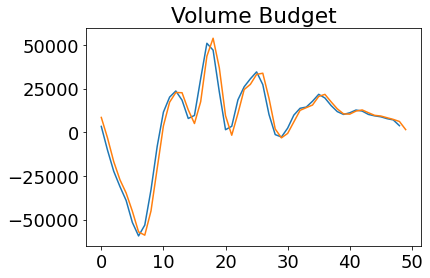

In [18]:
plt.plot(dVdt)
plt.plot(voladv)
plt.title('Volume Budget')

Text(0.5, 1.0, 'Volume integrated salinity Budget')

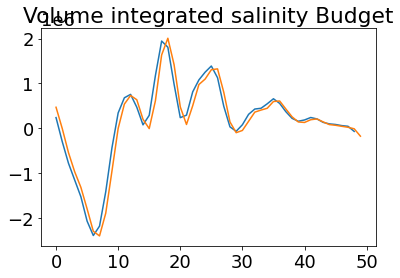

In [19]:
plt.plot(dsVdt)
plt.plot(saltadv)
plt.title('Volume integrated salinity Budget')

Text(0.5, 1.0, 'Salinity squared budget')

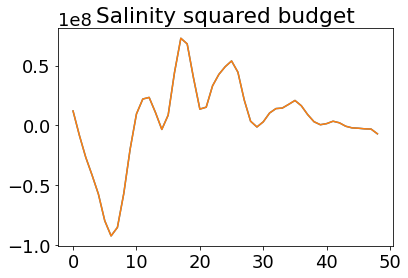

In [20]:
plt.plot(dssVdt)
plt.plot(ssadv-Mss)
plt.title('Salinity squared budget')

Text(0.5, 1.0, 'Salinity variance budget')

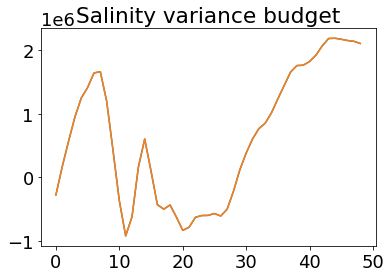

In [21]:
plt.plot(dsvardt)
plt.plot(svaradv-Msvar)
plt.title('Salinity variance budget')